## To learn more about AML pipelines and remote jobs please refer to https://github.com/Azure/azureml-examples

## This notebook was test using Python 3.8 - AzureML kernel

In [ ]:
%pip install azure-ai-ml

In [1]:
import azure.ai.ml 

In [2]:
# import required libraries
from azure.ai.ml import MLClient
from azure.identity import DefaultAzureCredential
from azure.ai.ml import command, Input
from azure.ai.ml.entities import (
    AzureBlobDatastore,
    AzureFileDatastore,
    AzureDataLakeGen1Datastore,
    AzureDataLakeGen2Datastore,
)
from azure.ai.ml.entities import Environment

In [3]:
# Enter details of your AML workspace
subscription_id = "xxxxxxxxx"
resource_group = "aml-v2-book"
workspace = "aml2-ws"

In [4]:
# get a handle to the workspace
ml_client = MLClient(
    DefaultAzureCredential(), subscription_id, resource_group, workspace
)

In [5]:
import pandas as pd
file_name = os.path.join('../chapter 2/my_data', "titanic.csv") 
df = pd.read_csv(file_name)
print(df.shape)
print(df.columns)

(891, 12)
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


In [6]:
df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

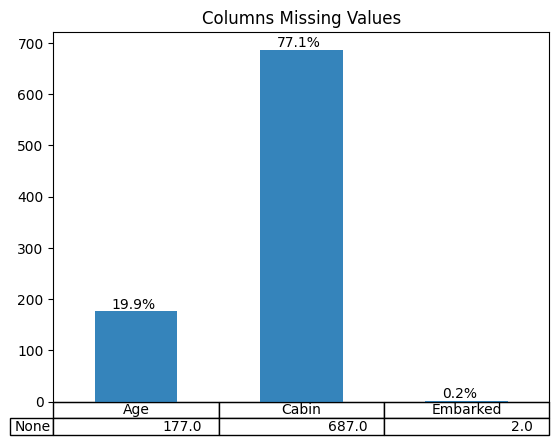

In [8]:
columns_missing = df.isna().sum().where(lambda x : x > 0).dropna()

ax = columns_missing \
.plot(kind='bar', alpha=0.9, title='Columns Missing Values', table=True)
ax.xaxis.set_visible(False) # hide x axis labels

for x in ax.patches:
    ax.text(x.get_x()+.1, x.get_height()+5, \
            str(round((x.get_height()/df.shape[0])*100, 1))+'%')

In [9]:
display(df.groupby(['Pclass', 'Sex'])['Age'].count())

display(df.groupby(['Pclass', 'Sex'])['Age'].median())

Pclass  Sex   
1       female     85
        male      101
2       female     74
        male       99
3       female    102
        male      253
Name: Age, dtype: int64

Pclass  Sex   
1       female    35.0
        male      40.0
2       female    28.0
        male      30.0
3       female    21.5
        male      25.0
Name: Age, dtype: float64

In [10]:
df['Age'] = df.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.median()))
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [11]:
df['Cabin'].unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [12]:
df['Loc']= df['Cabin'].apply(lambda x: x[0] if pd.notnull(x) else 'X')

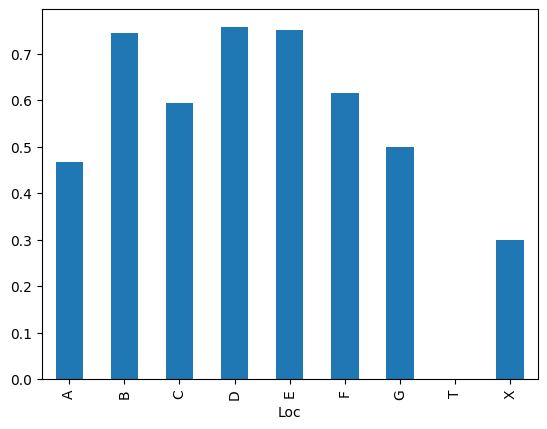

In [13]:
df[['Loc', 'Survived']].groupby('Loc')['Survived'].mean().plot(kind= 'bar')

In [14]:
df.drop(['Cabin', 'Ticket'], axis=1, inplace=True)

In [15]:
df.loc[:,'GroupSize'] = 1 + df['SibSp'] + df['Parch']

In [16]:
df['Embarked'] = df['Embarked'].fillna('S')

In [17]:
LABEL = 'Survived'
columns_to_keep = ['Pclass', 'Sex','Age', 'Fare', 'Embared', 'Deck', 'GroupSize']
columns_to_drop = ['Name','SibSp', 'Parch', 'Survived']
df_train = df
df = df_train.drop(['Name','SibSp', 'Parch', 'PassengerId'], axis=1)

df.head(5)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,male,22.0,7.2500,S,X,2
1,1,1,female,38.0,71.2833,C,C,2
2,1,3,female,26.0,7.9250,S,X,1
3,1,1,female,35.0,53.1000,S,C,2
4,0,3,male,35.0,8.0500,S,X,1


In [18]:
import os
script_folder = os.path.join(os.getcwd(), "clean_training_data")
print(script_folder)
os.makedirs(script_folder, exist_ok=True)

/mnt/batch/tasks/shared/LS_root/mounts/clusters/sifakhra3/code/chapter 3/clean_training_data


In [19]:
df.to_csv('./clean_training_data/titanic.csv')
df.head(2)

,Survived,Pclass,Sex,Age,Fare,Embarked,Loc,GroupSize
0,0,3,male,22.0,7.2500,S,X,2
1,1,1,female,38.0,71.2833,C,C,2


In [20]:
!pip install scikit-learn

2022/12/03 18:09:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.
2022/12/03 18:09:23 INFO mlflow.pyspark.ml: No SparkSession detected. Autologging will log pyspark.ml models contained in the default allowlist. To specify a custom allowlist, initialize a SparkSession prior to calling mlflow.pyspark.ml.autolog() and specify the path to your allowlist file via the spark.mlflow.pysparkml.autolog.logModelAllowlistFile conf.
2022/12/03 18:09:23 INFO mlflow.tracking.fluent: Autologging successfully enabled for pyspark.ml.
2022/12/03 18:09:24 WARNING mlflow.utils: Truncated the value of the key `steps`. Truncated value: `[('preprocessor', ColumnTransformer(n_jobs=None, remainder='drop', sparse_threshold=0.3,
                  transformer_weights=None,
                  transformers=[('numeric',
                                 Pipeline(memory=None,
                                          steps=[('scaler',
                                                  Standar

AUC: 0.8492261904761904
Accuracy: 0.8097014925373134


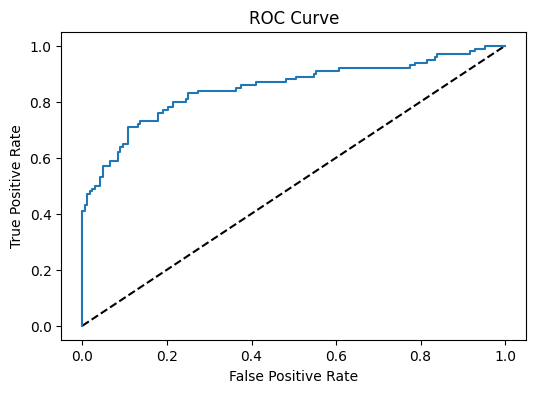

In [21]:
# Separate features and labels

import os
import argparse
import pandas as pd
from sklearn.model_selection import train_test_split
import logging
import mlflow
import argparse
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
import os
import pandas as pd
import mlflow

import sys
import argparse
import joblib
import numpy as np
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import roc_auc_score,roc_curve
# Calculate model performance metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


# Calculate model performance metrics
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

# Start Logging
experiment_name = 'titanic_local_compute'
mlflow.set_experiment(experiment_name)
# enable autologging
mlflow.sklearn.autolog()
mlflow.autolog()
# mlflow.autolog(log_models=False)
mlflow.start_run()

def buildpreprocessorpipeline(X_raw):
    categorical_features = X_raw.select_dtypes(include=['object']).columns
    numeric_features = X_raw.select_dtypes(include=['float','int64']).columns

    categorical_transformer = Pipeline(steps=[('imputer', SimpleImputer(strategy='constant', fill_value="missing")),
                                              ('onehotencoder', OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore'))])
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('numeric', numeric_transformer, numeric_features),
            ('categorical', categorical_transformer, categorical_features)
        ], remainder="drop")
    
    return preprocessor

def model_train(LABEL, df):  
    y_raw = df[LABEL]
    X_raw = df.drop([LABEL], axis=1)   
    # Train test split
    X_train, X_test, y_train, y_test = train_test_split(X_raw, y_raw, test_size=0.3, random_state=0)
    
    lg = LogisticRegression(penalty='l2', C=1.0, solver='liblinear')
    preprocessor = buildpreprocessorpipeline(X_train)
    
    #estimator instance
    clf = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', lg)])
    model = clf.fit(X_train, y_train)      
    # calculate AUC
    y_scores = model.predict_proba(X_test)
    auc = roc_auc_score(y_test,y_scores[:,1])
    print('AUC: ' + str(auc))
    mlflow.log_metric("AUC:", auc)
    
    # calculate test accuracy
    y_hat = model.predict(X_test)
    acc = np.average(y_hat == y_test)
    print('Accuracy:', acc)
    mlflow.log_metric("Accuracy:", acc)
    # plot ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_scores[:,1])
    fig = plt.figure(figsize=(6, 4))
    # Plot the diagonal 50% line
    plt.plot([0, 1], [0, 1], 'k--')
    # Plot the FPR and TPR achieved by our model
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()
    # plot confusion matrix
    # Generate confusion matrix
    cmatrix = confusion_matrix(y_test, y_hat)
    cmatrix_json = {
        "schema_type": "confusion_matrix",
           "schema_version": "v1",
           "data": {
               "class_labels": ["0", "1"],
               "matrix": [
                   [int(x) for x in cmatrix[0]],
                   [int(x) for x in cmatrix[1]]
               ]
           }
    }
    return model, auc, acc
    # Save the trained model
    
    
def main():

    df = pd.read_csv('./clean_training_data/titanic.csv')
    mlflow.log_metric("num_samples", df.shape[0])
    mlflow.log_metric("num_features", df.shape[1] - 1)

    model, auc, acc = model_train('Survived', df)
    
    os.makedirs('outputs', exist_ok=True)

    model_file = os.path.join('outputs', 'titanic_model.pkl')
    joblib.dump(value=model, filename=model_file)
    
#    mlflow.sklearn.log_model(model,model_file)
    # Register the model
     # Stop Logging
    mlflow.end_run()


if __name__ == "__main__":
    main()

In [22]:
mlflow.end_run()